## DVS Training Session 1

Introductory training using the Dish Verification System.

Essential reference: [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc)

                                                                        as of 4/07/2024

In [1]:
%pylab inline

# SARAO standard frameworks
import katpoint

# DVS-specific frameworks
from dvs import planning, fastgain, cbid2url, util
from analysis import katselib, katsepnt, fit_pointing_model

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/aph/work/dvs/libraries/analysis/katsemodels.py:1150: RuntimeWarning: divide by zero encountered in divide
  I_therm = lambda p, f_MHz: p[0] * (f_MHz/p[1])**2 * (1 - np.exp(-(f_MHz/p[1])**-2)) # The radiation intensity of a nebula in thermal equilibruim... Opacity tau(f)=(f/p[1])^2 fits the data.
/home/aph/work/dvs/libraries/analysis/katsemodels.py:1150: RuntimeWarning: invalid value encountered in multiply
  I_therm = lambda p, f_MHz: p[0] * (f_MHz/p[1])**2 * (1 - np.exp(-(f_MHz/p[1])**-2)) # The radiation intensity of a nebula in thermal equilibruim... Opacity tau(f)=(f/p[1])^2 fits the data.


## Planning

In [2]:
## Some available catalogues:
!ls ../catalogues

arrays		rfi_mask.txt	 targets_pnt_Ku.csv  targets_pnt_S.csv
fluxmodels.csv	sources_all.csv  targets_pnt_L.csv


Targets visible from antenna 'A0' at 2024-07-04 09:54:34.984 SAST, with flux density (Jy) evaluated at 1400 MHz

Target                        Azimuth    Elevation <    Flux Fringe period
------                        -------    --------- -    ---- -------------
Zenith                      0:00:00.0   90:00:00.0 -        
J0322-3712               -125:59:11.0   78:10:07.6 \   125.0
J0440-4333                157:32:39.3   75:56:51.9 /        
J0522-3627                115:41:37.5   73:57:02.7 /        
J0519-4546                143:08:22.0   69:51:51.4 /    66.6
J0535-0523                 42:27:41.7   57:45:40.6 /   364.1
J0408-6545               -179:26:02.0   55:01:34.9 -        
J0541-0153                 41:13:56.7   53:58:54.1 /    52.2
J0538-6904                168:12:44.9   49:40:37.0 /    40.6
J0627-0553                 59:17:04.0   49:27:53.1 /        
J0358+1026                 -4:15:11.3   48:41:29.9 -     9.8
J0046-4207               -120:12:43.3   48:01:24.7 \     8.3
J0408

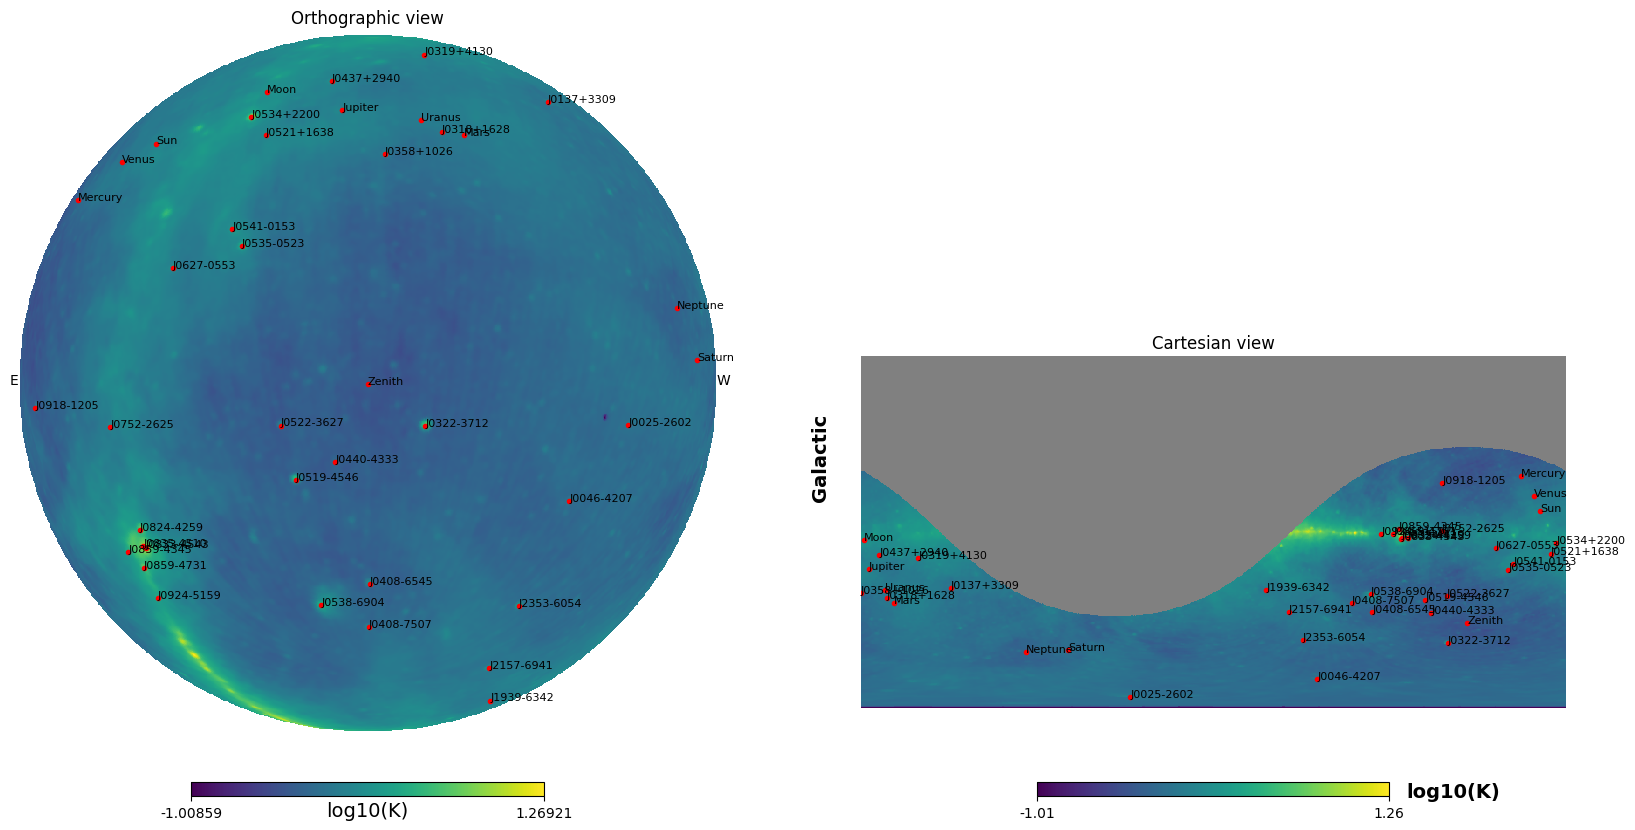

In [3]:
Tobs = katpoint.Timestamp().secs # or e.g. (2021,5,1, 6,0,0)
cat = planning.radiosky(Tobs, f_MHz=1400, catfn="../catalogues/sources_all.csv", el_limit_deg=10)

          Name |           Rise UTC |            Set UTC | Max Rate [deg/sec@1GHz]
--------------------------------------------------------------------------------
           Sun |  2024/7/4 07:28:55 |  2024/7/5 13:49:20 | 80.6
    J0534+2200 |  2024/7/4 06:07:21 |  2024/7/5 12:26:06 | 81.3
    J0535-0523 |  2024/7/4 04:40:21 |  2024/7/5 13:54:04 | 87.4
    J0918-1205 |  2024/7/4 08:06:51 |  2024/7/4 17:55:50 | 85.7
    J1651+0459 |  2024/7/4 16:21:05 |  2024/7/5 00:45:21 | -87.3
    J0519-4546 |  2024/7/4 02:55:09 |  2024/7/5 15:07:25 | 61.2
    J1230+1223 |  2024/7/4 12:23:57 |  2024/7/4 20:03:19 | 85.9
    J1939-6342 |  2024/7/4 16:12:42 |  2024/7/5 06:31:33 | -39.1


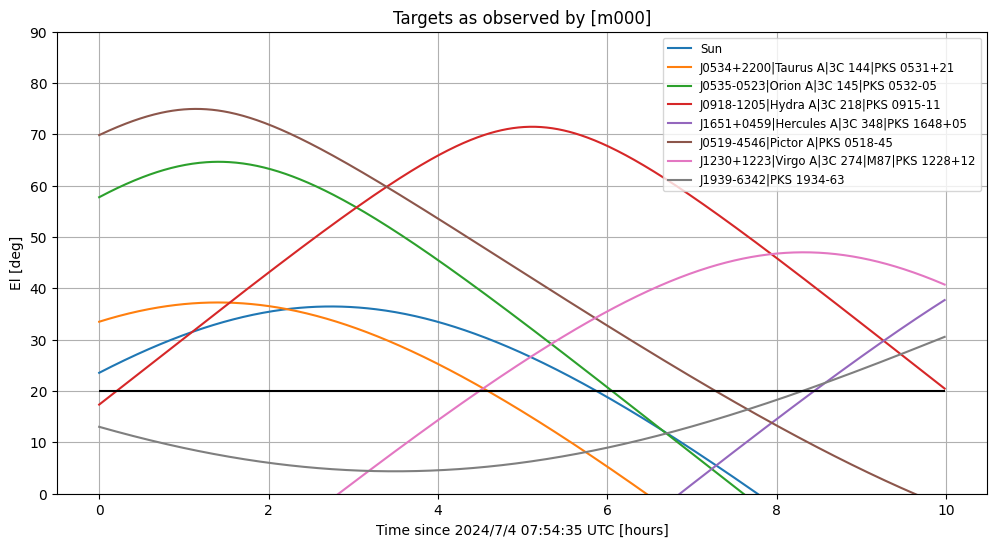

In [4]:
tgts = planning.describe_target("Sun|Taurus A|Orion A|Hydra A|Hercules A|Pictor A|Virgo A|PKS 1934-63",
                                catfn="../catalogues/fluxmodels.csv", horizon_deg=20, date=Tobs, end_date=Tobs+10*60*60,
                                figsize=(12,6))

## Observation - Manual Control
More info at [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc).

Open the signal displays and configure it to show spectrum & time-scrolling power & phase. Refer to the [Signal Display Manual](https://docs.google.com/document/d/1EdlZ2Wq4DLJs1QJZU0ktxODE8OO52fckyeeViDc5Yqc/edit).

Log on to obs.*???*.karoo.kat.ac.za and proceed with:
    
    ipython
    
    import katuilib
    configure_cam("all")
    
    cam.ants.req.target( cam.sources["J1745-2900"].description )
    cam.ants.req.mode("POINT")
    # At this point digitiser data & sensors are up & sensible
    
    cam.sdp.req.capture_init() # Prepare signal ingest & displays
    cam.cbf.req.capture_start()
    
    # Now F & X-engine data & sensors are valid, displays & ingest get valid data

Do some manual things and see how it plays out in the signal displays:

    cam.print_status("m049")
    
    cam.ants.req.dig_attenuation("h", 0); time.sleep(1);
    cam.ants.req.dig_attenuation("v", 0)
    cam.cbf.req.wide_gain_all(1024)
    
When you're done, finish as follows:
    
    cam.cbf.req.capture_stop()
    cam.sdp.req.capture_stop()
    # Now F & X-engine data, signal displays (and data recording) has halted
    cam.sdp.req.capture_done() # Finalize recording, ready for next cycle

Note: the above doesn't create a file in the archive.

## Observation - Radiometer Assessment
More info at [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc).

It is assumed that you have set up the signal path gains to your liking (previous section above), or are happy to record data with the currently active settings.

Log on to monctl.*???*.karoo.kat.ac.za and proceed with:

    ipython
    
    import katuilib
    configure_obs()
    
    obs.sb.new(owner='DVS')
    obs.sb.proposal_id = 'DVS-TRAINING-APH'
    obs.sb.type = katuilib.ScheduleBlockTypes.OBSERVATION
    obs.sb.controlled_resources_spec = "cbf,sdp"
    obs.sb.description = 'XX-band Short Term Gain Stability 200 sec'
    obs.sb.instruction_set = "run-obs-script /home/kat/dvs/observations/track.py -t 200 -n off -m 500 --no-delays 'SCP2000, radec, 0,-90' "
    obs.sb.to_defined()
    obs.sb.to_approved()
    
    obs.status()
    
Now start the observation via the GUI and follow progress on the signal displays.

In [5]:
recs = katselib.ls_archive("ProposalId:DVS-TRAINING-APH AND Description:Gain AND Stability",
                           fields=['CaptureBlockId','ExperimentID','StartTime','Antennas'])

1701857097 	20231206-0018 	2023-12-06T10:05:05Z 	['m049', 'm050']


CBF FFT shift:2047 0b11111111111
CBF requantization (equalization) gains:
[{'m049h': (1024+0j), 'm049v': (1024+0j)}]


/home/aph/venv-py3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/aph/venv-py3/lib/python3.8/site-packages/matplotlib/transforms.py:2868: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


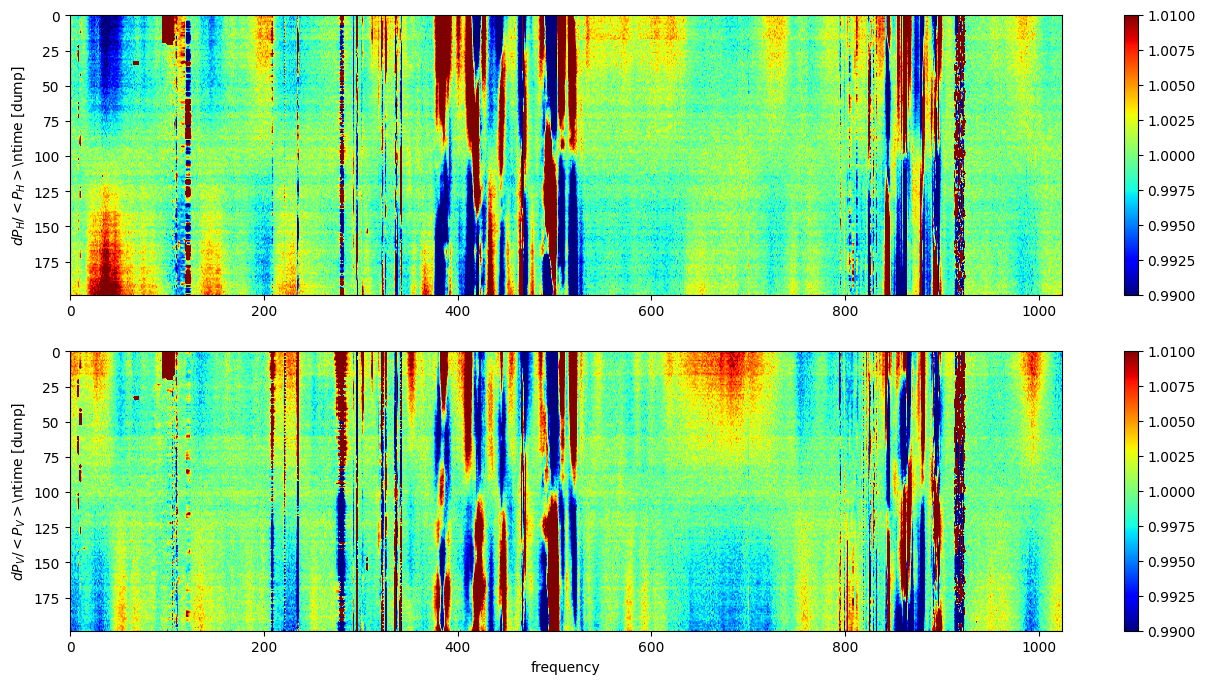

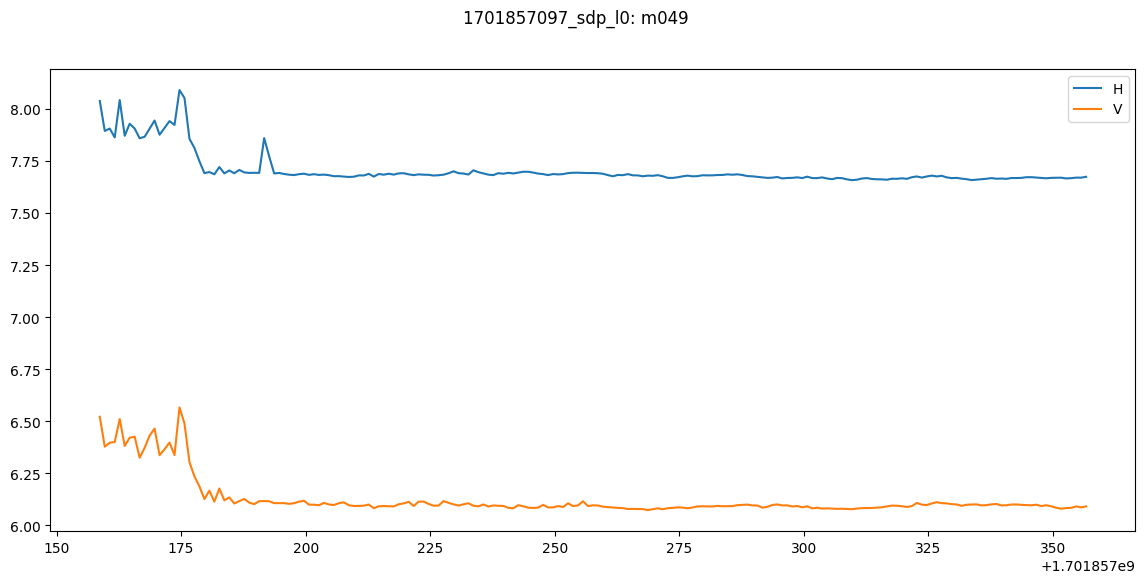

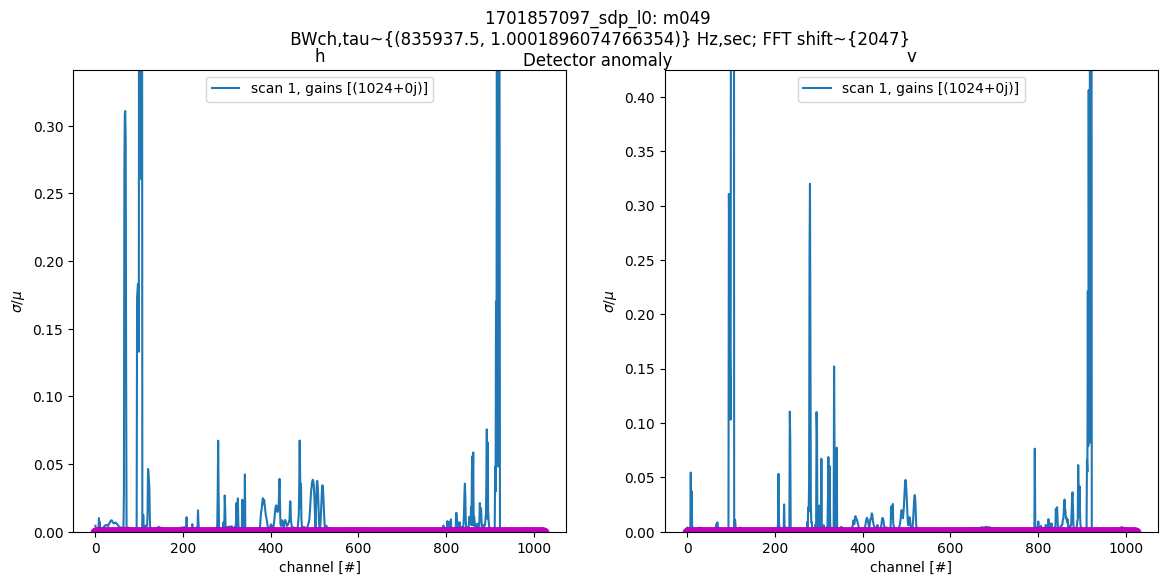

In [7]:
# Quick look at all datasets
for r in recs:
    cbid, ants = r['CaptureBlockId'], r['Antennas']
    fastgain.troubleshoot(util.open_dataset(cbid2url(cbid)), ants[0])

## Observation - Single Dish Pointing

More info at [DVS Operations Guide](https://docs.google.com/document/d/1mcpPv016eiNRHrLvt-Uu9z1ZOJPM4-2BknOOIALipIc) and also [MeerKAT Pointing Calibration Tutorial](https://docs.google.com/document/d/1BVpQM2ZVMHIRyjLLNlK4ecKWwXDmqVnaCdepRCbilLY/edit#heading=h.jm0yy9wwnyut).

Log on to monctl.*???*.karoo.kat.ac.za and proceed with:

    ipython
    
    import katuilib
    configure_obs()
    
    obs.sb.new(owner='DVS')
    obs.sb.proposal_id = 'DVS-TRAINING-APH'
    obs.sb.type = katuilib.ScheduleBlockTypes.OBSERVATION
    obs.sb.controlled_resources_spec = "cbf,sdp"
    obs.sb.description = 'XX-band Single Dish pointing'
    obs.sb.instruction_set = "run-obs-script /home/kat/dvs/observations/point_source_scan.py -n off -m 3600 -e --style=l /home/kat/katsdpscripts/RTS/sources_pnt_L.csv "
    obs.sb.to_defined()
    obs.sb.to_approved()
    
    obs.status()
    
This executes raster scan patterns (-e means scanning in elevation) over the targets in the catalogue for a total duration of 3600 seconds (60 mins). The --style-l scan pattern takes ~3 minutes and covers 2.6 x 2.6 degree extent in 8 slices.

Now start the observation via the GUI and follow progress on the signal displays.

In [8]:
recs = katselib.ls_archive("ProposalId:DVS-TRAINING-APH AND Description:pointing",
                          fields=['CaptureBlockId','ExperimentID','StartTime','Antennas'])

1701858025 	20231206-0019 	2023-12-06T10:20:28Z 	['m049', 'm050']


/home/aph/venv-py3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/aph/venv-py3/lib/python3.8/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/aph/venv-py3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/aph/venv-py3/lib/python3.8/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/aph/venv-py3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/aph/venv-py3/lib/py

[['PKS 2153-69', 0.32091608432910596, 0.36286716737865116],
 ['PKS 1934-63', 0.3798158525027658, 0.3996502940612501],
 ['PKS 1814-63', 1.6572435744652676, 0.8140241650436555],
 ['PKS 1610-60', 50.1365608209976, 54.4155483536238],
 ['PKS 2104-25', 0.13111948032180815, 0.20440826085438235],
 ['3C 353', 0.5576465622559682, 0.5375934580799689],
 ['Her A', 0.44179749566484355, 0.35304924402689863],
 ['Her A', 0.42590487969498675, 0.16317048868669848],
 ['3C 353', 0.11548527046630815, 0.08212512487857089]]

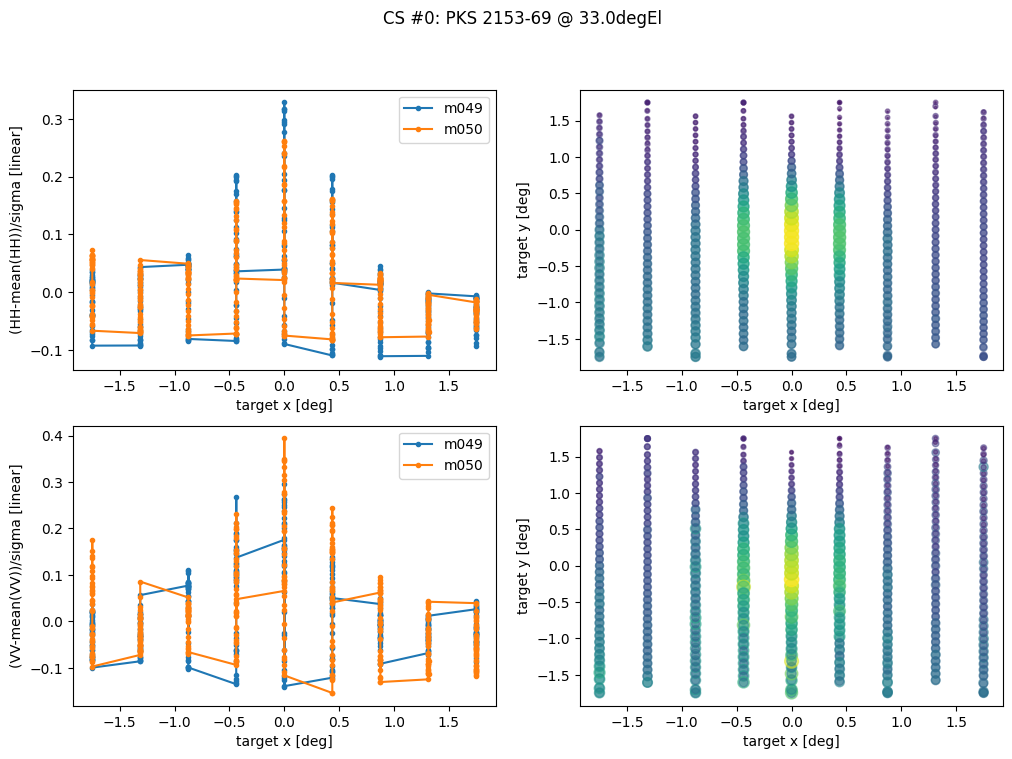

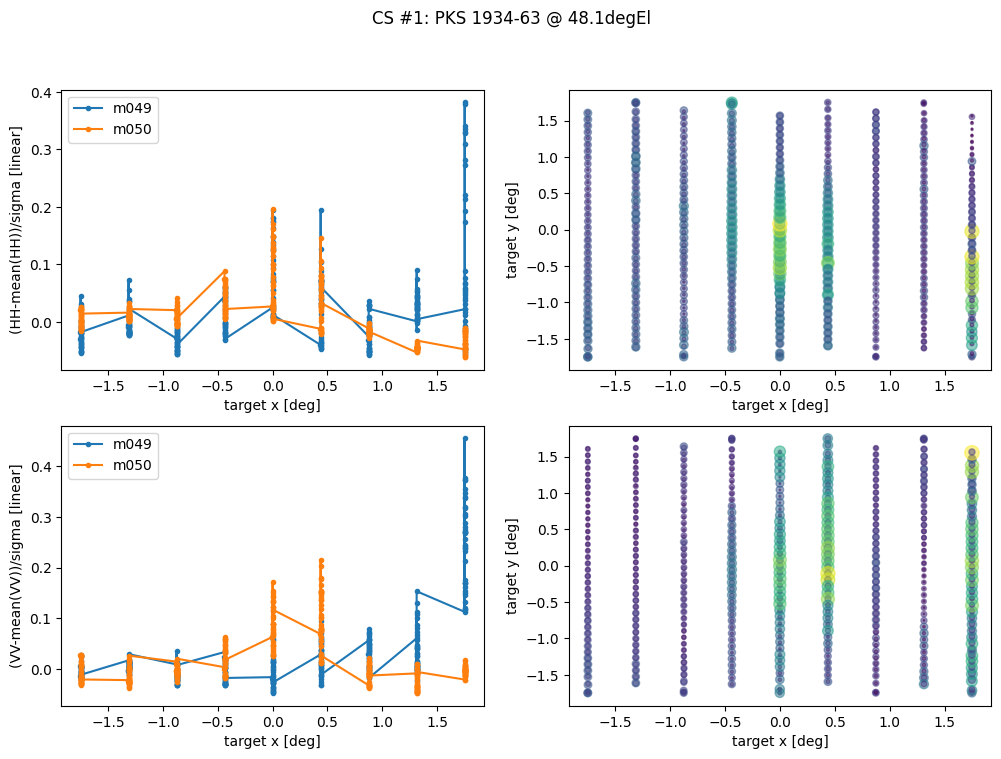

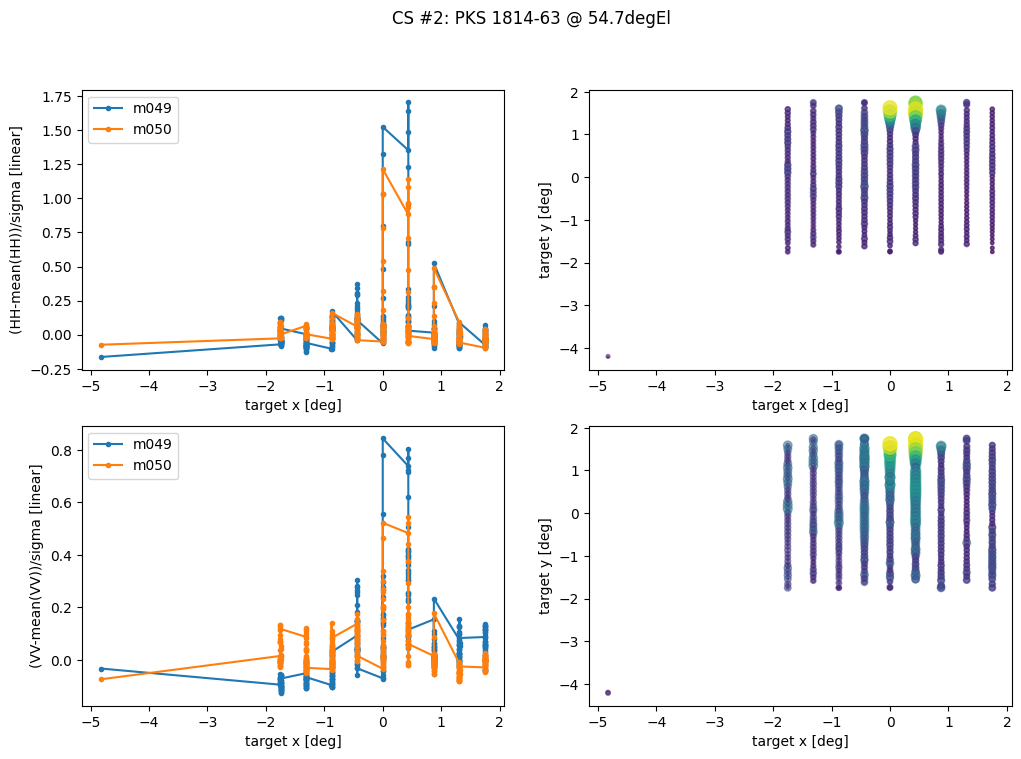

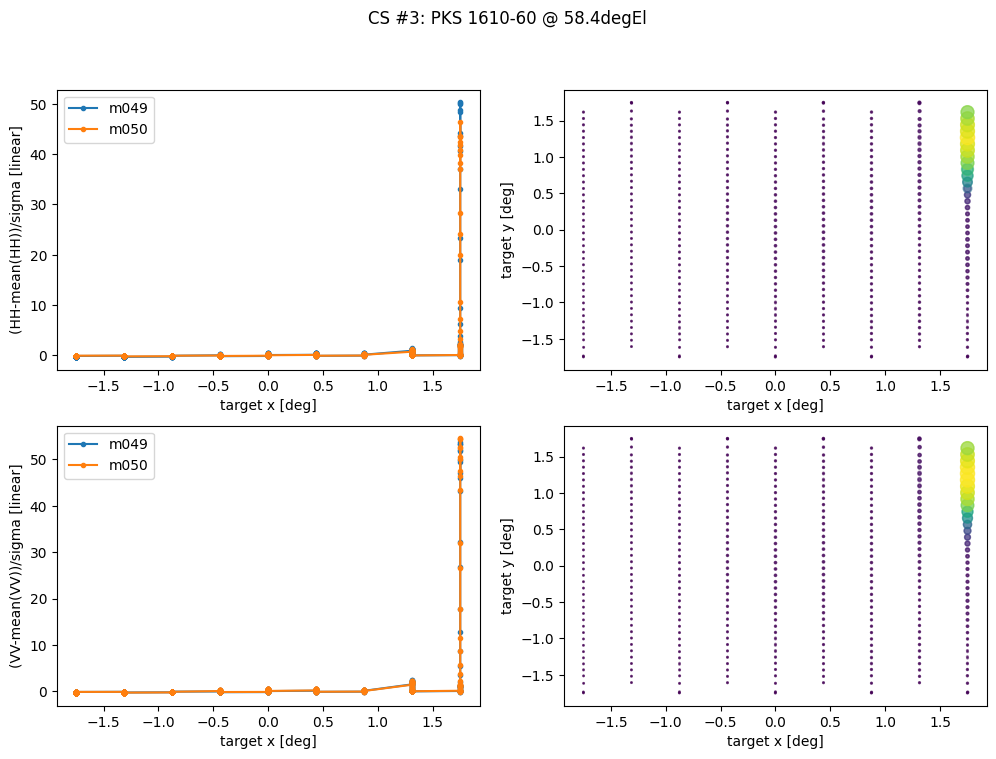

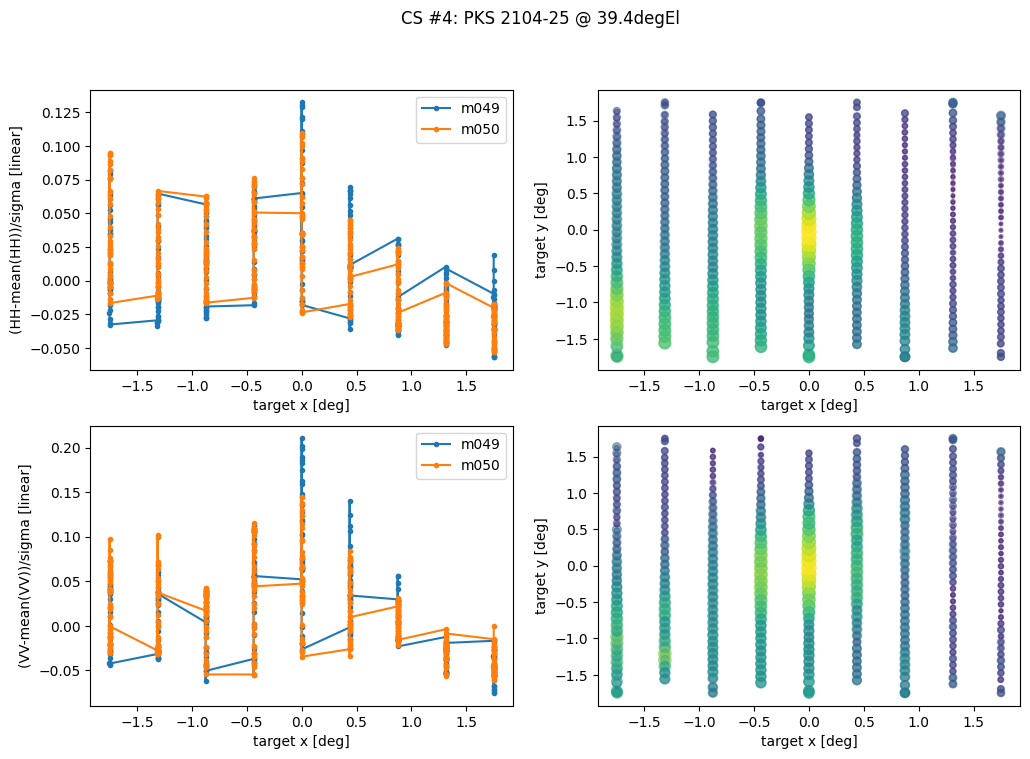

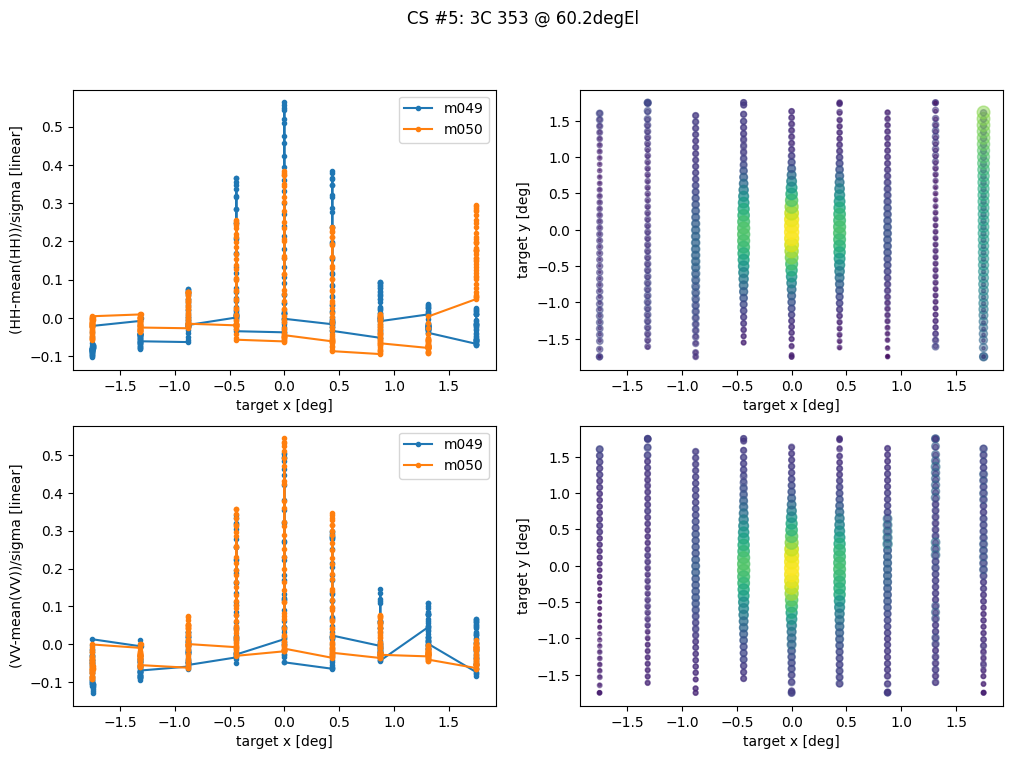

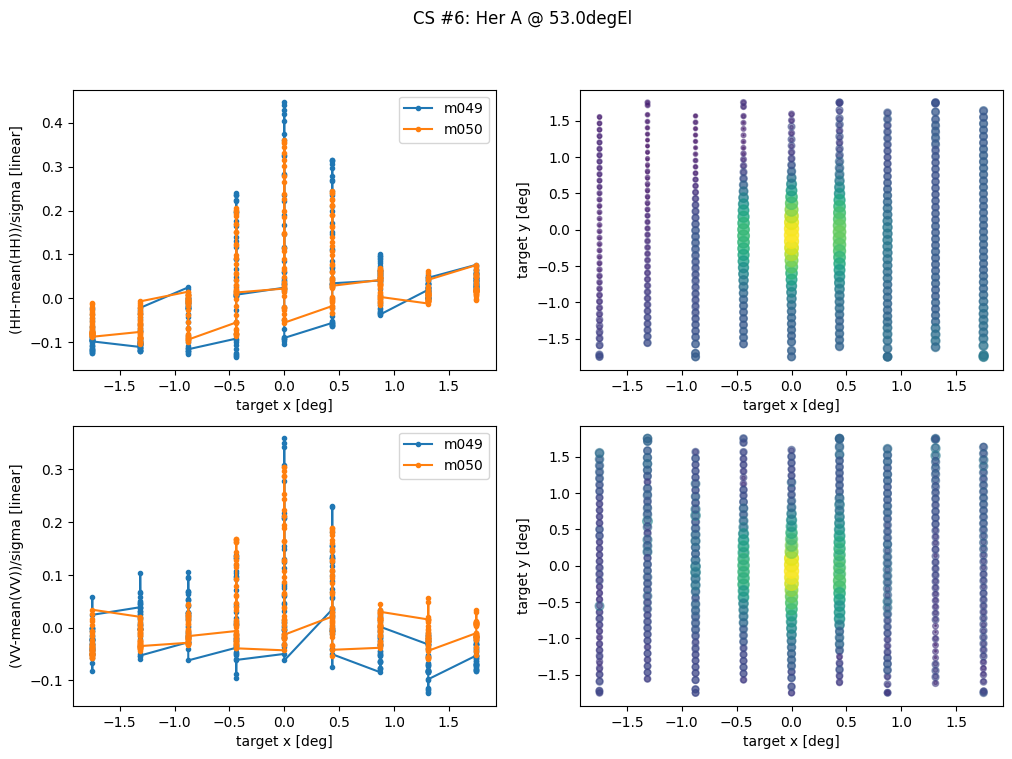

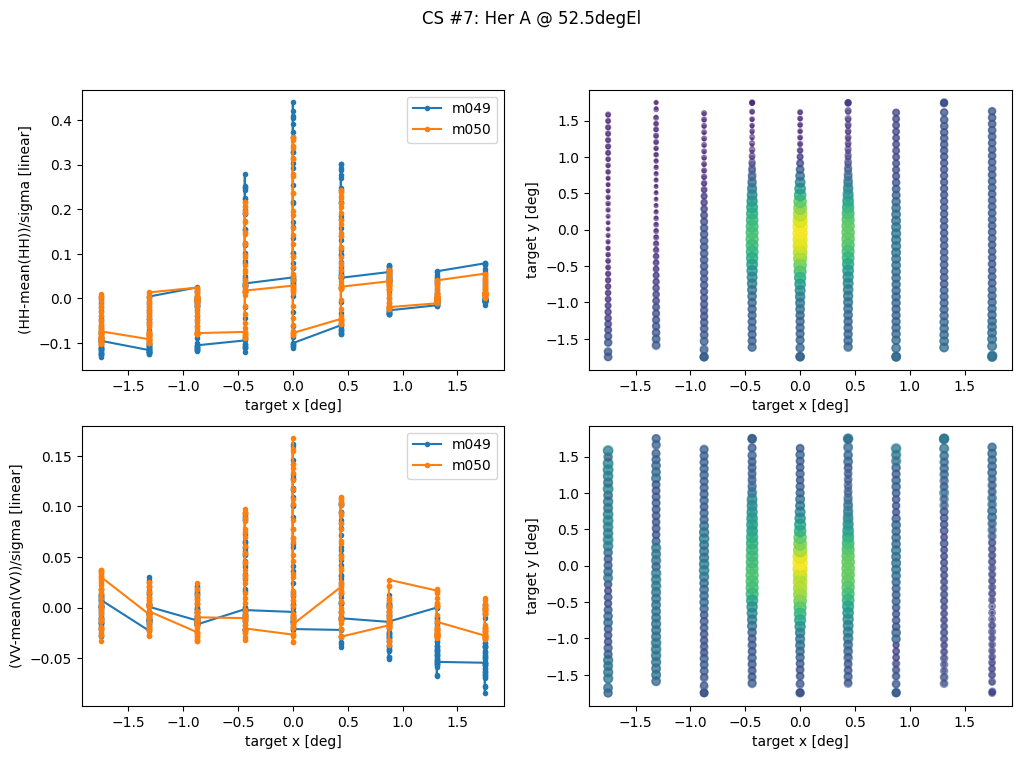

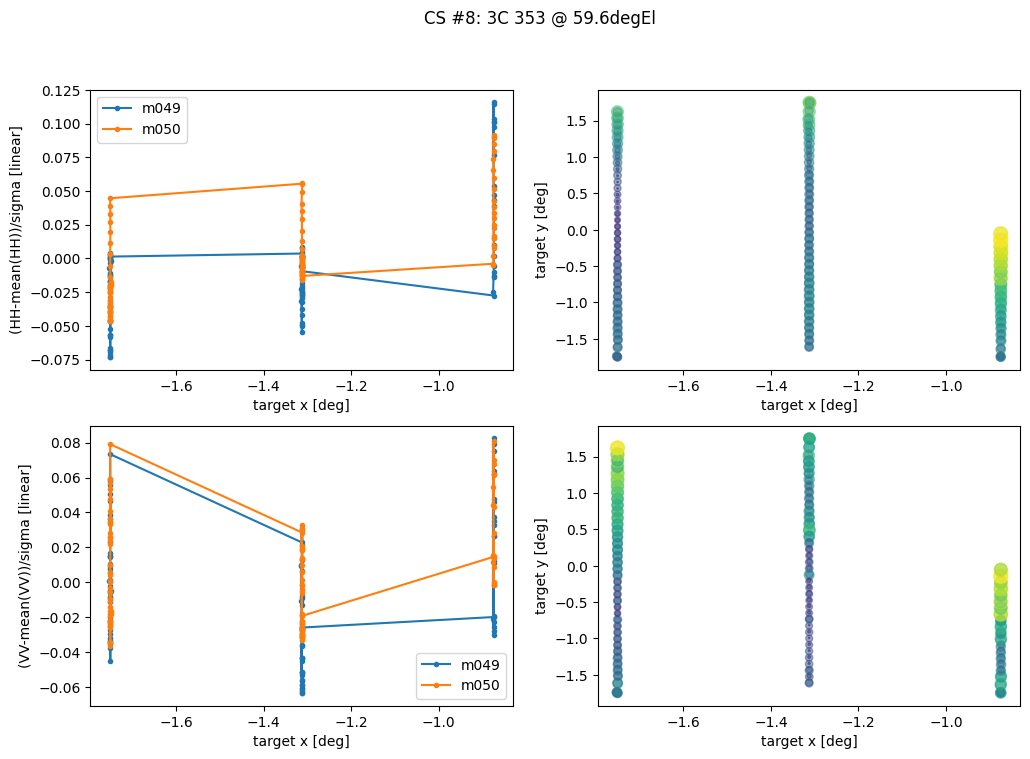

In [9]:
# Quick look at the first dataset
cbid, ants = recs[0]['CaptureBlockId'], recs[0]['Antennas']

katselib.plot_scans(util.open_dataset(cbid2url(cbid)), target_plane=True, ants=ants, pols=["HH","VV"])

In [20]:
# Fit centroids to the currently selected dataset
katsepnt.convert_pointingdataset(util.open_dataset(cbid2url(cbid)), ants='all', freq_chans="550,770", # RFI-free, see e.g fastgain.troubleshoot
                                 folder="./l2_data/pointing_results")

INFO:katsdptelstate.telescope_state:Loading 165 keys from <_io.BytesIO object at 0x7fb40f0e5eb8>
INFO:katdal.datasources:Using capture block '1701858025' and stream 'sdp_l0'
INFO:root:Loading dataset '1701858025_sdp_l0'
INFO:scape.katdal_dataset:Loading baseline 'm049,m049'
INFO:scape.katdal_dataset:Defaulting to 'coupler' noise diode (either no or both diodes are firing)


Name: 1701858025_sdp_l0 (version 4.0)
-------------------------------------------------------------------------------
URL: http://archive-gw-1.kat.ac.za/1701858025/1701858025_sdp_l0.full.rdb
Observer: DVS  Experiment ID: 20231206-0019
Description: 'DVS: L-band Single Dish pointing'
Observed from 2023-12-06 12:20:28.336 SAST to 2023-12-06 13:20:29.018 SAST
Dump rate / period: 0.99981 Hz / 1.000 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m049,m050                            4       12
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M1k    1284.000         856.000           1024       835.938
-------------------------------------------------------------------------------
Data selected according to the following criteria:
  ants=['m049', 'm050']
  spw=0
  subarray=0
-------------------------------------------------------------------------------
Shape: (3600 dumps, 1024 channels, 12 corre

INFO:root:==== Processing compound scan 1 of 9: 'm049 1701858025_sdp_l0 scan 1 PKS 2153-69 2023-12-06 10:24:12.378' ====
INFO:root:==== Processing compound scan 2 of 9: 'm049 1701858025_sdp_l0 scan 19 PKS 1934-63 2023-12-06 10:31:15.458' ====
INFO:root:==== Processing compound scan 3 of 9: 'm049 1701858025_sdp_l0 scan 39 PKS 1814-63 2023-12-06 10:38:11.537' ====
INFO:root:==== Processing compound scan 4 of 9: 'm049 1701858025_sdp_l0 scan 57 PKS 1610-60 2023-12-06 10:45:16.618' ====
INFO:root:==== Processing compound scan 5 of 9: 'm049 1701858025_sdp_l0 scan 75 PKS 2104-25 2023-12-06 10:53:00.206' ====
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch2/adriaan/venv-py3/local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:==== Processing compound scan 6 of 9: 'm049 

No. of lines incl. headers 	Filename
10 		 ./pointing_results/1701858025_sdp_l0_m049_point_source_scans.csv
10 		 ./pointing_results/1701858025_sdp_l0_m050_point_source_scans.csv


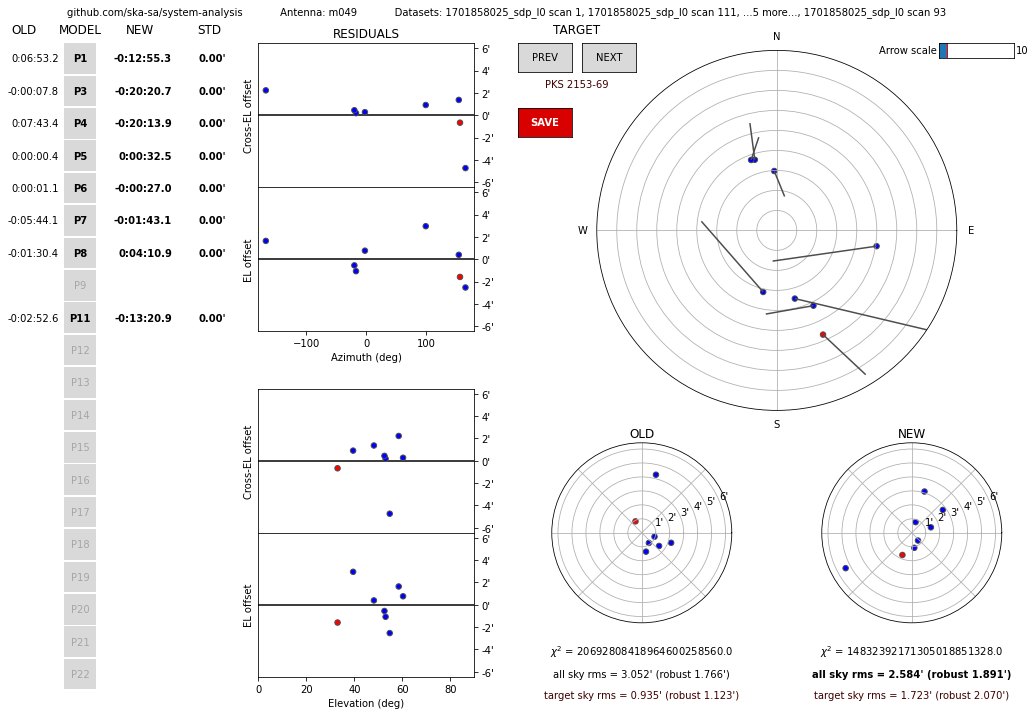

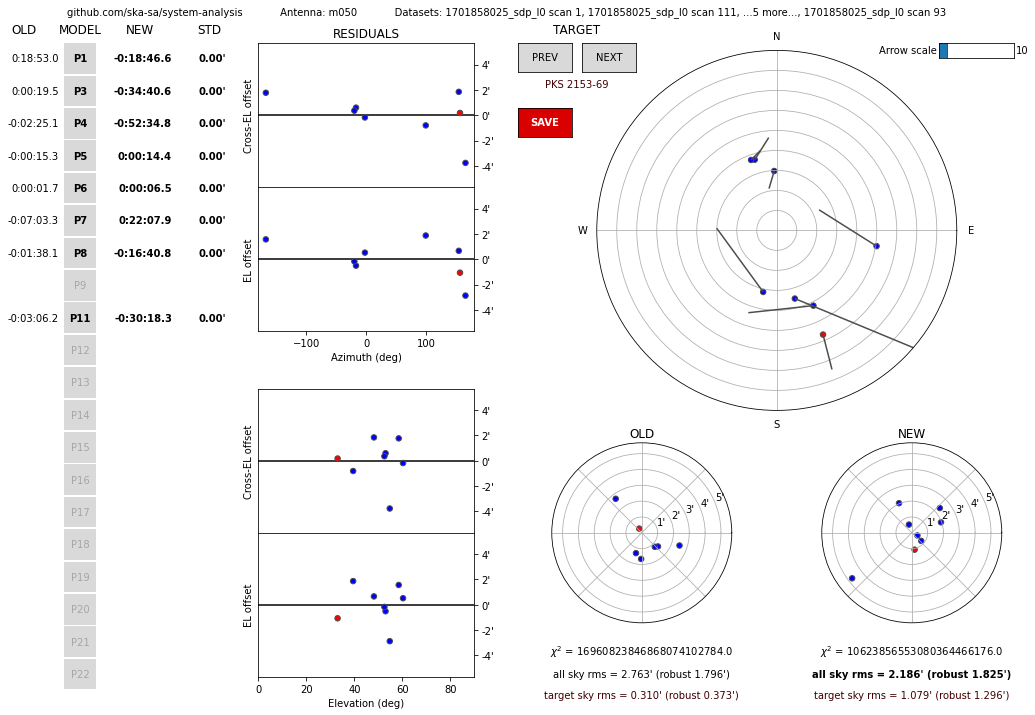

In [21]:
# Quick look at the pointing measurement set
for ant in ants:
    fit_pointing_model.fit_model(f"./l2_data/pointing_results/{cbid}_sdp_l0_{ant}_point_source_scans.csv",
                                 enabled_params=[1,3,4,5,6,7,8,11])

# Note: running fit_pointing_model.py ./l2_data/pointing_results/...csv in the command terminal makes the figures below interactive!

/home/aph/work_dvs/dvs/libraries/systems-analysis/analysis/katsepnt.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  r2_adjusted = 1 - (1-r2)*(n-1)/(n-p)
/home/aph/work_dvs/dvs/libraries/systems-analysis/analysis/katsepnt.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  r2_adjusted = 1 - (1-r2)*(n-1)/(n-p)


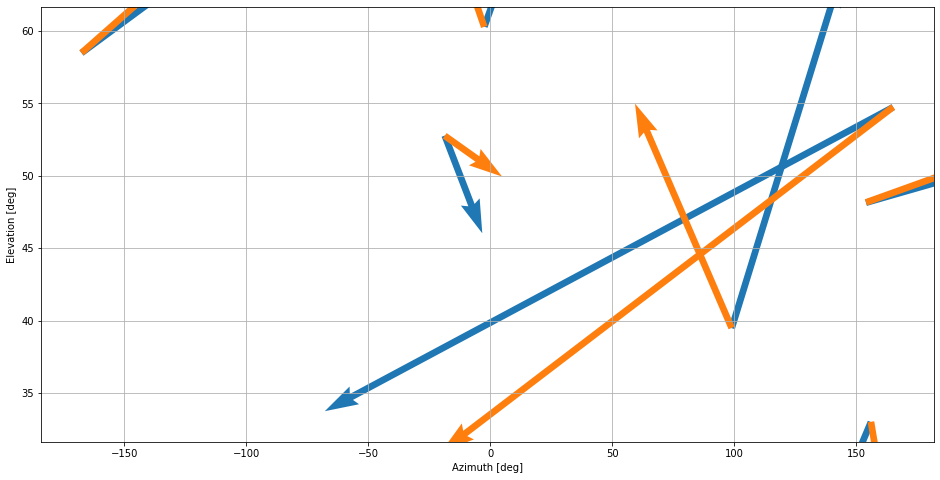

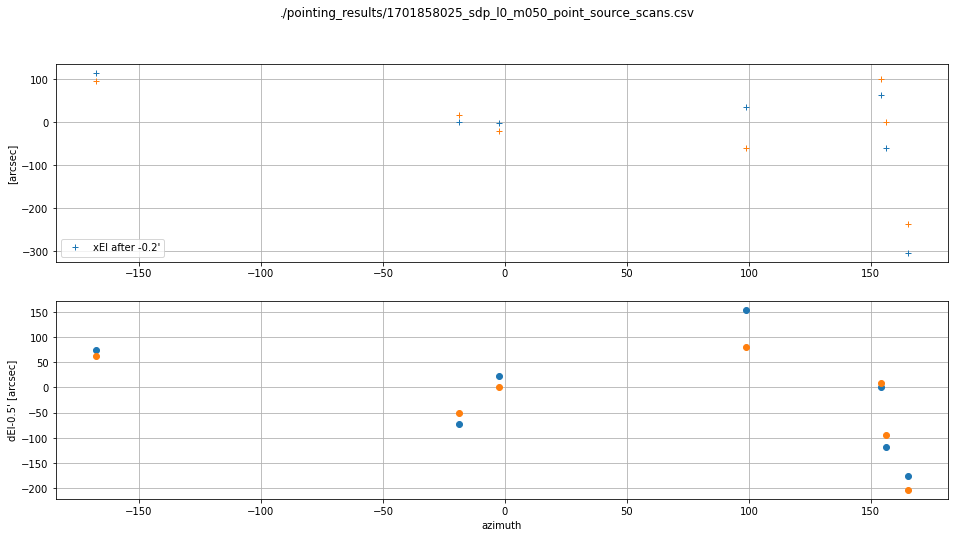

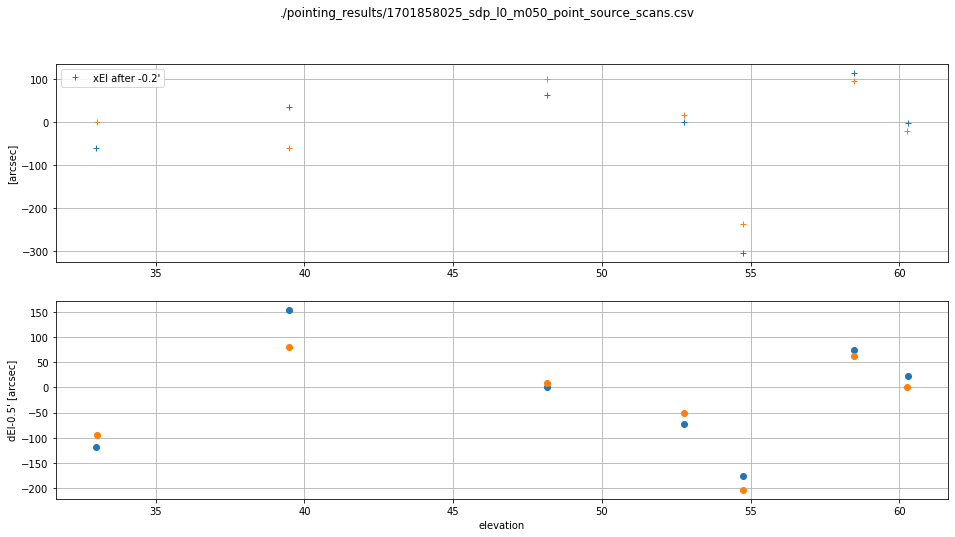

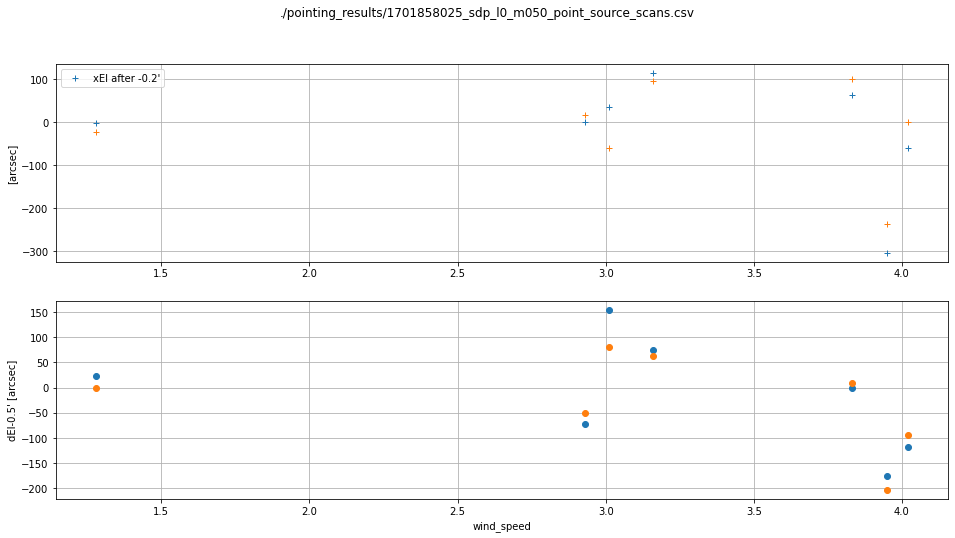

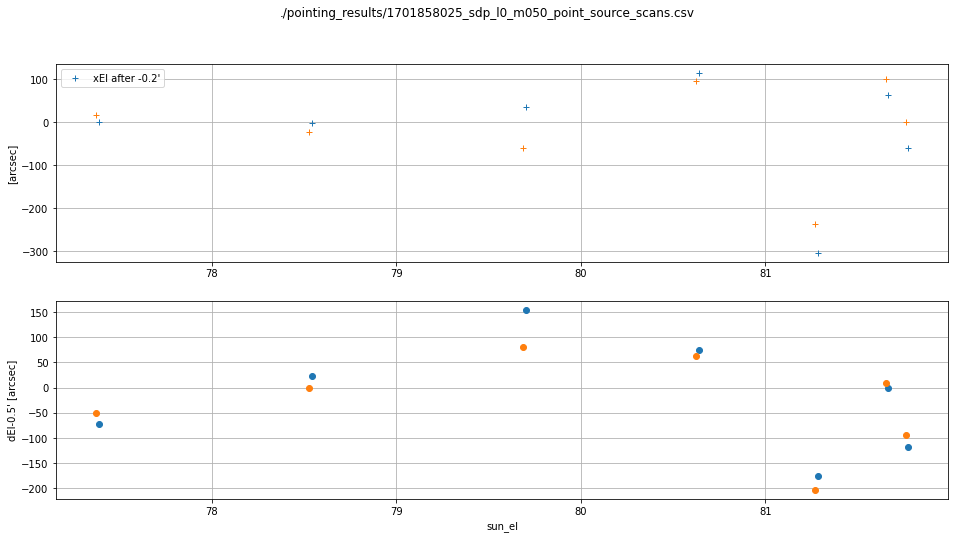

In [22]:
# Look for trends
figs = []
for ant in ants:
    katsepnt.eval_pointingstability([f"./l2_data/pointing_results/{cbid}_sdp_l0_{ant}_point_source_scans.csv"],
                                    update_model=True, Pplus=[1,3,4,5,6,7,8,11],
                                    metrics=["azimuth","elevation","wind_speed","sun_el"], figs=figs)